# Receiver Operator Characteristic (ROC) curve

Frequently in machine learning we wish to go beyond measuring raw accuracy. This is especially true when classes are unbalanced, where errors are often greater in one class than the other. The Receiver Operator Characteristic (ROC) curve allows us to better understand the trade-off between sensitivity (the ability to detect positives of a certain class) and specificity (the ability to detect negatives of a certain class). The area under the ROC curve is also often used to compare different models: a higher Area Under Curve (AUC) is frequently the sign of a better model.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The true-positive rate is also known as sensitivity or recall. The false-positive rate can be calculated as (1 − specificity).# Measuring model accuracy with K-fold stratification

In our previous example using logistic regression to classify passengers as likely to survive the Titanic, we used a random split for training and test data. But doing a single assessment like this may lead to an inaccurate assesment of the accuracy.

We could use repeated random splits, but a more robust method is to use ‘stratified k-fold validation’. In this method the model is repeated k times, so that all the data is used once, but only once, as part of the test set. This, alone, is k-fold validation. Stratified k-fold validation adds an extra level of robustness by ensuring that in each of the k training/test splits, the balance of outcomes represents the balance of outcomes (between survivors and non-survivors)in the overall data set. Most commonly 5 or 10 different splits of the data are used.

Here we use scikit-learn's methods for ROCs.

*In this notebook we assume that you have run through the basic logistic regression example in the previous example. We will not explain all steps fully*.

## Load modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

## Download data

Run the following code if data for Titanic survival has not been previously downloaded.

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Load data and cast all data as float (decimal)

The loading of data assumes that data has been downloaded and saved. 

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

In [4]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
# We drop passenger ID as it is not original data

data.drop('PassengerId', inplace=True, axis=1)

## Divide into X (features) and y (labels)

We will split into features (X) and label (y) and convert from a Pandas DataFrame to NumPy arrays. NumPy arrays are simpler to refer to by row/column index numbers, and sklearn's k-fold method provides row indices for each set.

In [5]:
# Split data into two DataFrames
X_df = data.drop('Survived',axis=1)
y_df = data['Survived']

# Convert DataFrames to NumPy arrays
X = X_df.values
y = y_df.values

## Define function to standardise data
Standardisation subtracts the mean and divides by the standard deviation, for each feature.
Here we use the sklearn built-in method for standardisation.

In [6]:
def standardise_data(X_train, X_test):
    """
    Converts all data to a similar scale.
    Standardisation subtracts mean and divides by standard deviation
    for each feature.
    Standardised data will have a mena of 0 and standard deviation of 1.
    The training data mean and standard deviation is used to standardise both
    training and test set data.
    """
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

## Fir the model for each k-fold

We will fit the model and store the predicted probabilities for each run. alongisde the actual classificiation for each passenger.

In [7]:
# Set up lists for observed and predicted
observed = []
predicted_proba = []
predicted = []

# Set up splits
number_of_splits = 5
skf = StratifiedKFold(n_splits = number_of_splits)
skf.get_n_splits(X, y)

# Loop through the k-fold splits
counter = 0
for train_index, test_index in skf.split(X, y):
    counter += 1
    
    # Get X and Y train/test
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Standardise X data
    X_train_std, X_test_std = standardise_data(X_train, X_test)
    
    # Set up and fit model
    model = LogisticRegression(solver='lbfgs')
    model.fit(X_train_std,y_train)
    
    # Get predicted probabilities
    y_probs = model.predict_proba(X_test_std)[:,1]
    y_class = model.predict(X_test_std)
    observed.append(y_test)
    predicted_proba.append(y_probs)
    
    # Print accuracy
    accuracy = np.mean(y_class == y_test)
    print (
        f'Run {counter}, accuracy: {accuracy:0.3f}')    

Run 1, accuracy: 0.788
Run 2, accuracy: 0.803
Run 3, accuracy: 0.775
Run 4, accuracy: 0.775
Run 5, accuracy: 0.803


## Get Receiver Operator Characteristic (ROC) Area Under Curve (AUC)

Scikit-Learn's ROC method will automatically test the rate of true postive rate (tpr) and false positive rate (fpr) at different thresholds of classification. It will return tpr, fpr for each threshold tested. We also use Scikit-Learn's method for caluclating the area under the curve.

In [8]:
# Set up lists for results
k_fold_fpr = [] # false positive rate
k_fold_tpr = [] # true positive rate
k_fold_thresholds = [] # threshold applied
k_fold_auc = [] # area under curve

# Loop through k fold predictions and get ROC results 
for i in range(5):
    # Get fpr, tpr and thresholds foir each k-fold from scikit-learn's ROC method
    fpr, tpr, thresholds = roc_curve(observed[i], predicted_proba[i])
    # Use scikit-learn's method for calulcating auc
    roc_auc = auc(fpr, tpr)
    # Store results
    k_fold_fpr.append(fpr)
    k_fold_tpr.append(tpr)
    k_fold_thresholds.append(thresholds)
    k_fold_auc.append(roc_auc)
    # Print auc result
    print (f'Run {i} AUC {roc_auc:0.4f}')

# Show mean area under curve  
mean_auc = np.mean(k_fold_auc)
sd_auc = np.std(k_fold_auc)
print (f'\nMean AUC: {mean_auc:0.4f}')
print (f'SD AUC: {sd_auc:0.4f}')

Run 0 AUC 0.8308
Run 1 AUC 0.8279
Run 2 AUC 0.8632
Run 3 AUC 0.8360
Run 4 AUC 0.8724

Mean AUC: 0.8461
SD AUC: 0.0182


## Plot ROCs

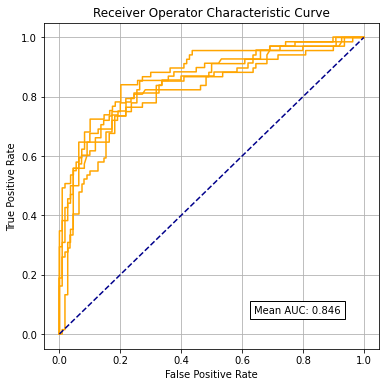

In [9]:
fig = plt.figure(figsize=(6,6))

# Plot ROC
ax1 = fig.add_subplot()
for i in range(5):
    ax1.plot(k_fold_fpr[i], k_fold_tpr[i], color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'Mean AUC: {mean_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)
plt.show()